In [2]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import csv
import datetime
import gsw
import glob
import matplotlib as mpl
import matplotlib.cm as cm
#import matplotlib.colormaps as cmaps
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mpl_toolkits.axes_grid1.inset_locator as inset_axes
import numpy as np
from numpy import linspace
import os
import pandas as pd
#import rasterio.plot
import scipy.io
#import seaborn as sns
import seawater
import seawater.eos80 as sw
import xarray as xr
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from shapely.geometry import LineString, MultiLineString, Point, Polygon
from shapely.ops import unary_union


mpl.style.use('seaborn-muted')
#mpl.rc('font', family ='Arial')

/tmp/ipykernel_377352/4008220302.py:36: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-muted')


In [ ]:
########################################################################################################
########################################################################################################
############################################# loading data #############################################
########################################################################################################
########################################################################################################

In [3]:
import glob

headers = []
csv_cast_lat_lon = {}
csv_ctd_data_dict = {}

# directory where the csv files are stored
csv_dir = r"/darnley/CDMeanState/Data/Final/Seal_CTD_and_Argo_type"

# can choose what files to exclude. s04i_97 has an error with oxygen readings below a certain depth, so can remove it this way
# exclude_file = "s04i_97_updated.csv"
exclude_file = "1987_bAU002712_wod_010114182O.nc_153_derivedvariables_ordered_type.csv"


for filename in glob.glob(os.path.join(csv_dir, "*.csv")):
    # can comment this line out if want all the files
    if os.path.basename(filename) != exclude_file:
        # read the csv file
        first = True
        try:
            csv_filehandle = open(filename)
            # print(filename)
            csvfile = csv.reader(csv_filehandle)
        except:
            # print("load fail")
            continue

        # get the file name without the directory path and file extension
        fn = os.path.splitext(os.path.basename(filename))[0]

        # initialize the data structure
        csv_ctd_data_dict[fn] = {}
        
        # Flag variable to check if 'time' column is found
        time_column_found = False
        
        # Flag to check if salinity < 20 is found
        low_salinity_found = False
        
        for row in csvfile:
            if first:
                header = row

                first = False
                for i in range(len(row)):
                    headers.append(row[i])
                    csv_ctd_data_dict[fn][row[i]] = []
                    
                    # Check if 'time' column exists in the header
                    if row[i] == 'time':
                        time_column_found = True

                # If 'time' column is not found, print the error and break
                if not time_column_found:
                    print(f"'time' column not found in file: {filename}")
                    break

            else:
                # Convert salinity to a float and check if it's less than 20
                salinity = float(row[2])  # Assuming salinity is at index 2
                if salinity < 20:
                    low_salinity_found = True
                    print(f"Low salinity found in file: {filename}")
                    break
                
                for i in range(len(row)):
                    csv_ctd_data_dict[fn][headers[i]].append(float(row[i]))

        csv_cast_lat_lon[fn] = {'lat': np.mean(csv_ctd_data_dict[fn]['latitude']), 'lon': np.mean(csv_ctd_data_dict[fn]['longitude'])}

# Print a message if no files with low salinity were found
if not low_salinity_found:
    print("No files with salinity < 20 were found.")

print(csv_cast_lat_lon)


No files with salinity < 20 were found.
{'2016_bAU005882_wod_017871129O.nc_325_derivedvariables_ordered_type': {'lat': -65.702, 'lon': 69.86799999999997}, '2010_bUS025289_wod_015285970O.nc_101_derivedvariables_ordered_type': {'lat': -65.981674, 'lon': 71.21315000000001}, '2017_bIN001232_wod_018153585O.nc_348_derivedvariables_ordered_type': {'lat': -65.965, 'lon': 64.149}, '2022_bAU006636_wod_021308761O.nc_684_derivedvariables_ordered_type': {'lat': -66.76154999999999, 'lon': 64.3392}, 'cnv_subset_PS128_033_01_DOWN_1m_updated_type': {'lat': -64.13699999999999, 'lon': 64.39866667000001}, '2001_bAU003608_wod_011280931O.nc_171_derivedvariables_ordered_type': {'lat': -66.33320000000002, 'lon': 64.0752}, '2022_bAU006485_wod_021968351O.nc_717_derivedvariables_ordered_type': {'lat': -65.51823000000002, 'lon': 67.99732}, '2011_bAU003979_wod_015205537O.nc_38_derivedvariables_ordered_type': {'lat': -65.86199999999997, 'lon': 69.22000000000003}, '2020_bIN001353_wod_020347777O.nc_539_derivedvariabl

In [4]:
#check it loaded all the files 
len(csv_cast_lat_lon)

1148

In [5]:
##run this code to order the dictionary by lat & lon
## i origingally did this when I had less casts and had a legend instead of a colour bar, so not really necessary, 
## but i use this dictionary in code later on so it does'nt hurt to do it or you will have to change the dictionary you call in plots below

csv_lon_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lon']))
csv_lat_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lat']))

In [6]:
# Define the latitude range you want to plot
lat_min = -67
lat_max = -66.5

# Define the longitude range you want to plot
lon_min = 63
lon_max = 73

# Initialize empty lists for each variable
temperature_list = []
cons_temperature_list = []
salinity_list = []
abs_salinity_list = []
oxygen_list = []
latitude_list = []
longitude_list = []
pressure_list = []
depth_list = []
neutral_density_list = []
time_list = []
type_list = []


# Loop over the dictionary and extract the data for each variable
for cast in csv_ctd_data_dict.values():
    temperature_list.append(cast['temperature'])
    cons_temperature_list.append(cast['conservative temperature'])
    salinity_list.append(cast['salinity'])
    abs_salinity_list.append(cast['absolute salinity'])
    try:
        oxygen_list.append(cast['oxygen'])
    except KeyError:
        pass
    #oxygen_list.append(cast['oxygen'])
    latitude_list.append(cast['latitude'])
    longitude_list.append(cast['longitude'])
    pressure_list.append(cast['pressure'])
    depth_list.append(cast['depth'])
    neutral_density_list.append(cast['neutral density'])
    time_list.append(cast['time'])
    type_list.append(cast['type'])



# Convert the lists to NumPy arrays
temperature = np.concatenate(temperature_list)
cons_temperature = np.concatenate(cons_temperature_list)
salinity = np.concatenate(salinity_list)
abs_salinity = np.concatenate(abs_salinity_list)
oxygen = np.concatenate(oxygen_list)
latitude = np.concatenate(latitude_list)
longitude = np.concatenate(longitude_list)
pressure = np.concatenate(pressure_list)
depth = np.concatenate(depth_list)
neutral_density = np.concatenate(neutral_density_list)
time = np.concatenate(time_list)
type = np.concatenate(type_list)

In [7]:
#load colour maps
cmap_temp = cmocean.cm.thermal
cmap_salt = cmocean.cm.haline
cmap_dens = cmocean.cm.dense
cmap_deep = cmocean.cm.deep
cmap_ice = cmocean.cm.ice

# #old way of getting these that got updated
#cmap_temp = plt.cm.get_cmap('cmo.thermal')
# cmap_salt = plt.cm.get_cmap('cmo.haline')
# cmap_dens = plt.cm.get_cmap('cmo.dense')
# cmap_deep = plt.cm.get_cmap('cmo.deep')


In [8]:
#split data up into argo, seal & ship so can make them different markers in plots

seals_data = type == 1
ships_data = type == 2
argo_data = type == 3

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]

argo_latitude = latitude[argo_data]
argo_longitude = longitude[argo_data]
argo_cons_temperature = cons_temperature[argo_data]
argo_abs_salinity = abs_salinity[argo_data]
argo_depth = depth[argo_data]
argo_neutral_density = neutral_density[argo_data]
argo_time = time[argo_data]

In [ ]:
### the argo data is a bit weird and has some NaNs so this code is to get rid of them

nan_indices = np.isnan(argo_abs_salinity)
print("Indices of NaN values in argo_cons_temperature:", np.where(nan_indices)[0])

In [ ]:
# Create a mask to identify rows with NaN values in argo_cons_temperature
nan_mask = np.isnan(argo_cons_temperature)

print(nan_mask)

# Apply the mask to all argo data arrays

argo_latitude = argo_latitude[~nan_mask]
argo_longitude = argo_longitude[~nan_mask]
argo_cons_temperature = argo_cons_temperature[~nan_mask]
argo_abs_salinity = argo_abs_salinity[~nan_mask]
argo_depth = argo_depth[~nan_mask]
argo_neutral_density = argo_neutral_density[~nan_mask]
argo_time = argo_time[~nan_mask]

In [ ]:
nan_indices = np.isnan(argo_time)
print("Indices of NaN values in argo_cons_temperature:", np.where(nan_indices)[0])

In [ ]:
########################################################################################################
########################################################################################################
############################################ visualise data ############################################
########################################################################################################
########################################################################################################

In [9]:
#load bathymetry data

# Open the NetCDF file with xarray
gebco_full = xr.open_dataset('../Data/Final/bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')

<Figure size 640x480 with 0 Axes>

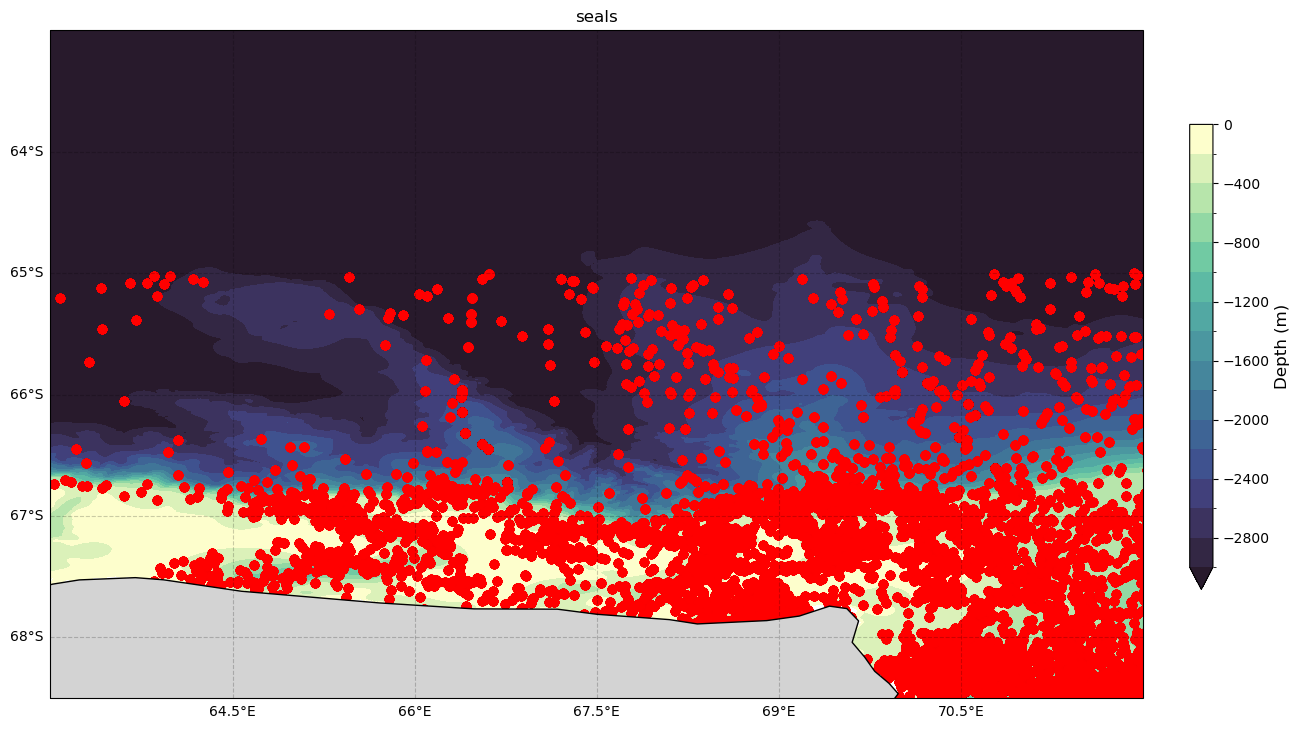

In [9]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot the contour polygon
ax.scatter(seals_longitude, seals_latitude, color='red')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('seals')

plt.show()

<Figure size 640x480 with 0 Axes>

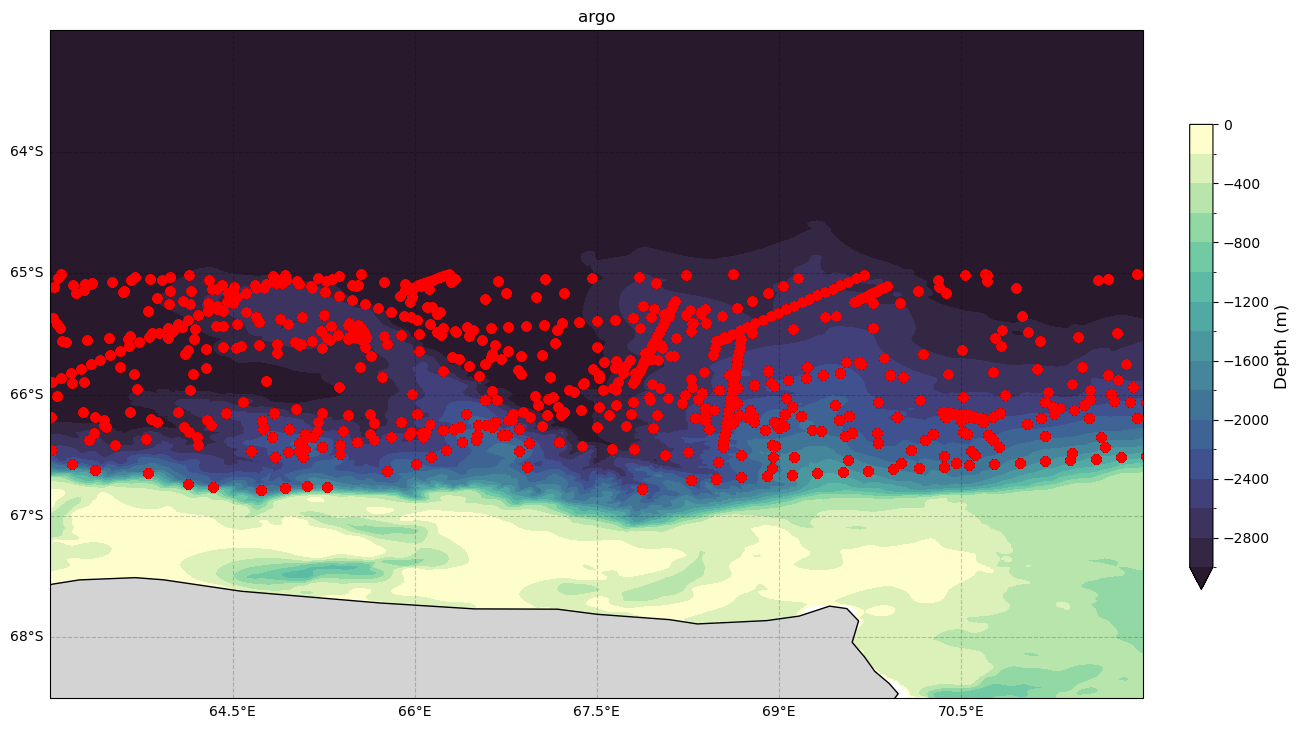

In [10]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot the contour polygon
ax.scatter(argo_longitude, argo_latitude, color='red')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('argo')

plt.show()

<Figure size 640x480 with 0 Axes>

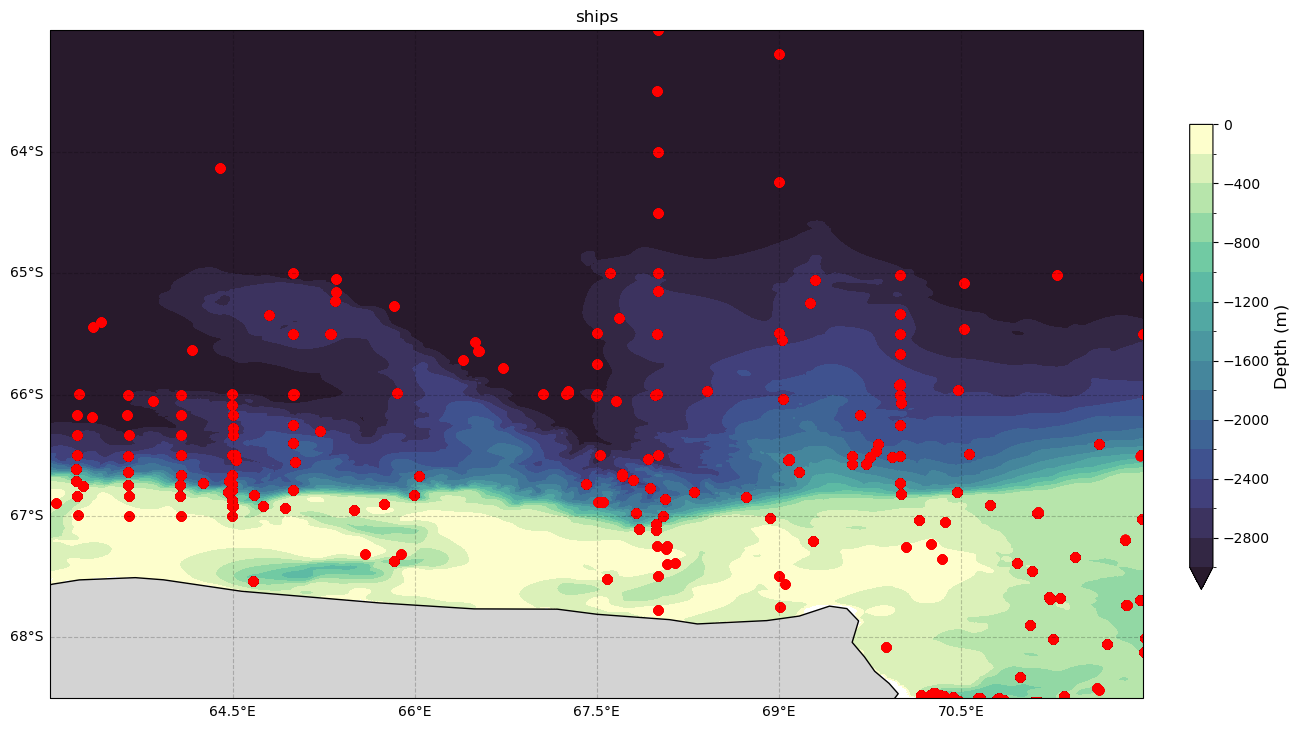

In [11]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot the contour polygon
ax.scatter(ships_longitude, ships_latitude, color='red')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('ships')

plt.show()

In [ ]:
########################################################################################################
########################################################################################################
######################################## Gridded layers plotting #######################################
########################################################################################################
########################################################################################################

In [10]:
#load in the 600m contour 
shelf_contour = np.load('contour_coordinates_shelf_600m.npy')

In [11]:
#load in the 2000m contour 
slope_contour = np.load('contour_coordinates_slope_2000m.npy')

In [12]:
# Add land feature and set its facecolor
land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgrey')

In [74]:
# Filter data based on criteria (neutral_density < 28 and depth < 2000)
# #AASW
criteria_indices = np.where((neutral_density < 28) & (depth < 700))
# #CDW/mCDW
#old indices
#criteria_indices = np.where((neutral_density > 28) & (neutral_density < 28.27))
#new indices
# criteria_indices = np.where((neutral_density > 28) & (neutral_density < 28.27) & (cons_temperature > -1.95))
# #DSW, mSW, AABW
# criteria_indices = np.where(neutral_density > 28.27)
# #DSW
# criteria_indices = np.where((neutral_density > 28.27) & (depth < 700) & (latitude < -66.5))
# # #mSW, AABW
# criteria_indices = np.where((neutral_density > 28.27) & (depth > 700) & (latitude > -66.5))
# ISW
# criteria_indices = np.where(cons_temperature < -1.95)


# Create a DataFrame with the filtered data
filtered_data = pd.DataFrame({
    'latitude': latitude[criteria_indices],
    'longitude': longitude[criteria_indices],
    'depth': depth[criteria_indices],
    'absolute salinity': abs_salinity[criteria_indices],
    'conservative temperature': cons_temperature[criteria_indices]
})


# Group the data by unique latitude and longitude and calculate thickness
grouped = filtered_data.groupby(['latitude', 'longitude'])
thickness = grouped['depth'].apply(lambda x: np.max(x) - np.min(x)).reset_index(name='thickness')
mean_abs_salinity = grouped['absolute salinity'].mean().reset_index(name='mean_abs_salinity')
mean_cons_temperature = grouped['conservative temperature'].mean().reset_index(name='mean_cons_temperature')

# Filter the data to remove rows with thickness == 0
thickness_filtered = thickness[thickness['thickness'] != 0]

# print(thickness)
# print(thickness_filtered)
#print(mean_cons_temperature)


/tmp/ipykernel_198328/612630657.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_deep = plt.cm.get_cmap('cmo.deep')


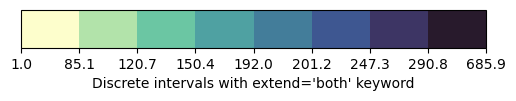

In [14]:
#just some old code for different type of colour bar

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap_deep = plt.cm.get_cmap('cmo.deep')

# Calculate percentiles to divide the data into 8 equal parts
#percentiles = np.percentile(thickness['thickness'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
percentiles = np.percentile(thickness_filtered['thickness'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
# percentiles = [0, 20, 50, 100, 500, 750, 1000, 1250, 1500]

norm = mpl.colors.BoundaryNorm(percentiles, cmap_deep.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword")

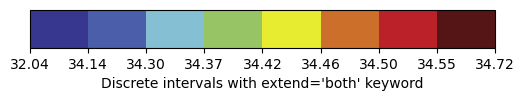

In [75]:
#absolute salinity

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# cmap_deep = plt.cm.get_cmap('cmo.deep')
cmap_deep = mpl.colors.ListedColormap(['#373790', '#4a5ea9', '#85bfd3', '#97c464', '#e8ec31', '#cc6f2a', '#bb2128', '#551416'])

# Calculate percentiles to divide the data into 8 equal parts
#data that has zeroes
#percentiles = np.percentile(thickness['thickness'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
#thickness data with no zeroes
#percentiles = np.percentile(thickness_filtered['thickness'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
#how to set manual values for colour bar ticks
# percentiles = [0, 20, 50, 100, 500, 750, 1000, 1250, 1500]
# #for mean cons temp
# percentiles = np.percentile(mean_cons_temperature['mean_cons_temperature'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
#for mean abs salt
percentiles = np.percentile(mean_abs_salinity['mean_abs_salinity'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%

def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)

norm = mpl.colors.BoundaryNorm(percentiles, cmap_deep.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword", format=formatter)

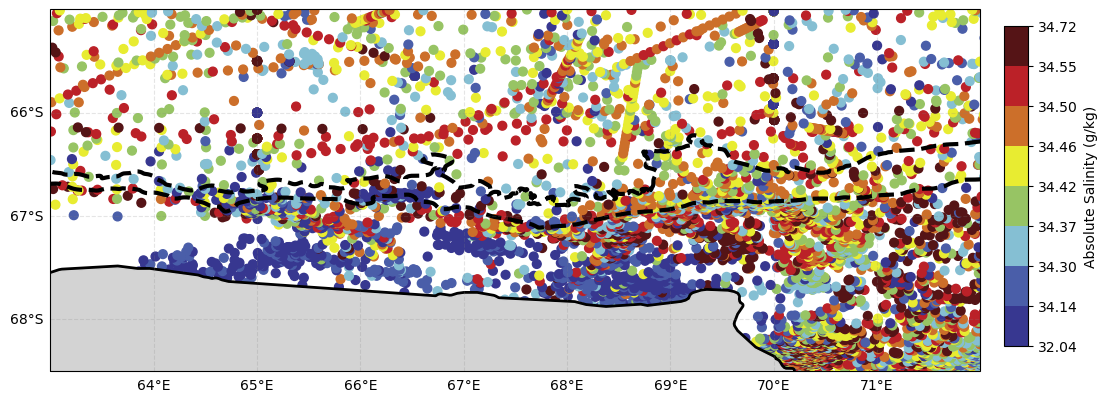

In [76]:
#absolute salinity

# Set up the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
ax.set_extent([63, 72, -68.5, -65], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 73, 1), ylocs=np.arange(-69, -63, 1))
gl.right_labels = False
gl.top_labels = False
gl.ylocator = mticker.FixedLocator([-69, -68, -67, -66, -65])


# Plot the thickness data on the map
# #thickness
# sc = ax.scatter(thickness['longitude'], thickness['latitude'], c=thickness['thickness'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)
#mean cons temp 
#sc = ax.scatter(mean_cons_temperature['longitude'], mean_cons_temperature['latitude'], c=mean_cons_temperature['mean_cons_temperature'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)
#mean abs salt 
sc = ax.scatter(mean_abs_salinity['longitude'], mean_abs_salinity['latitude'], c=mean_abs_salinity['mean_abs_salinity'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)


#old original colourbar code
#plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both', label='Thickness (m)')



def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)

# Create a color bar axes
cax = plt.axes([0.92, 0.3, 0.02, 0.4])  # [x, y, width, height]
# Create the color bar using the ScalarMappable
#thickness
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Thickness (m)', format=formatter)
#mean cons temp 
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Conservative Temperature (°C)', format=formatter)
#mean abs salt 
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Absolute Salinity (g/kg)', format=formatter)

#plot 600m contour
ax.plot(shelf_contour[:, 0], shelf_contour[:, 1], color='black', linewidth=3, linestyle='--')
#plot 2000m contour
ax.plot(slope_contour[:, 0], slope_contour[:, 1], color='black', linewidth=3, linestyle='--')

# cbar = plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
# cbar.set_label(f'Thickness (m)', fontsize=11)

# plt.title('Thickness of Criteria: Neutral Density < 28 kg/m$^3$, Depth < 700m')
#plt.title('Thickness of Criteria: Neutral Density 28 < y$^n$ < 28.27 kg/m$^3$')
plt.show()


In [77]:
# create 2 grids, one for the sum total, and one that has the count of points within grid. Then divide grids by eachother to find the mean 


# Create a DataFrame from the NumPy array
data = pd.DataFrame(mean_abs_salinity, columns=['latitude', 'longitude', 'mean_abs_salinity'])


# Define the grid resolution (0.1 degrees in this case) and the range of latitudes and longitudes you want to cover:
lat_resolution = 0.1
lon_resolution = 0.1

min_lat = -69
max_lat = -63
min_lon = 63
max_lon = 73


# Create empty grids for latitude, longitude, and salinity totals
latitudes = np.arange(min_lat, max_lat + lat_resolution, lat_resolution)
longitudes = np.arange(min_lon, max_lon + lon_resolution, lon_resolution)
total_salinity_grid = np.zeros((len(latitudes), len(longitudes)))
count_grid = np.zeros((len(latitudes), len(longitudes)))


# Iterate through each data point and accumulate the salinity values into the corresponding grid cell
for index, row in data.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    salinity = row['mean_abs_salinity']

    lat_index = int((lat - min_lat) / lat_resolution)
    lon_index = int((lon - min_lon) / lon_resolution)

    total_salinity_grid[lat_index, lon_index] += salinity
    count_grid[lat_index, lon_index] += 1


# Replace zero values in total_salinity_grid with NaN where count is zero
total_salinity_grid[count_grid == 0] = np.nan
# or this line if you want it to do less than x no. of point (e.g. if less than 3 data points, make nan)
# total_salinity_grid[(count_grid == 0) | (count_grid <= 2)] = np.nan


# access the salinity value for a specific grid cell by indexing the salinity_grid
# For example, to get the total salinity at latitude 42.5 and longitude -120.3:
lat_index = int((-67 - min_lat) / lat_resolution)
lon_index = int((65.3 - min_lon) / lon_resolution)

total_salinity = total_salinity_grid[lat_index, lon_index]
count_grid_value = count_grid[lat_index, lon_index]

print(total_salinity)
print(count_grid_value)




# Divide total_salinity_grid by count_grid to calculate the mean
mean_salinity_grid = np.divide(total_salinity_grid, count_grid)

# Access the mean salinity value for a specific grid cell by indexing the mean_salinity_grid
# For example, to get the mean salinity at latitude -67 and longitude 65.3:
mean_salinity = mean_salinity_grid[lat_index, lon_index]

print(mean_salinity)


205.7341026485446
6.0
34.28901710809077


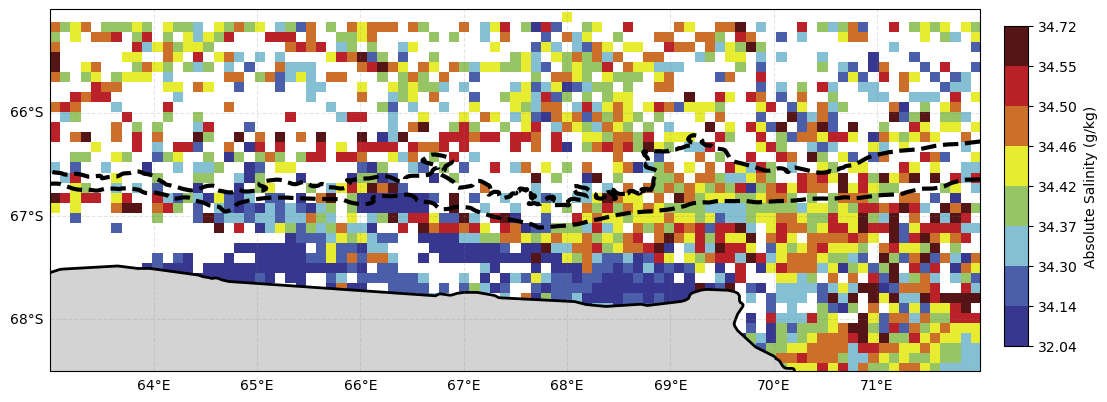

In [78]:
#gridded absolute salinity
# Set up the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
ax.set_extent([63, 72, -68.5, -65], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 73, 1), ylocs=np.arange(-69, -63, 1))
gl.right_labels = False
gl.top_labels = False


# Plot the salinity grid
plt.imshow(mean_salinity_grid, extent=[min_lon, max_lon, min_lat, max_lat], cmap=cmap_deep, origin='lower', transform=ccrs.PlateCarree(), norm=norm)

#old original colourbar code
#plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both', label='Thickness (m)')


def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)


# Create a color bar axes
cax = plt.axes([0.92, 0.3, 0.02, 0.4])  # [x, y, width, height]
# Create the color bar using the ScalarMappable
#thickness
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Thickness (m)', format=formatter)
# #mean cons temp 
# plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Conservative Temperature (°C)', format=formatter)
#mean abs salt 
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Absolute Salinity (g/kg)', format=formatter)

#plot 600m contour
ax.plot(shelf_contour[:, 0], shelf_contour[:, 1], color='black', linewidth=3, linestyle='--')
#plot 2000m contour
ax.plot(slope_contour[:, 0], slope_contour[:, 1], color='black', linewidth=3, linestyle='--')


# cbar = plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
# cbar.set_label(f'Thickness (m)', fontsize=11)

# plt.title('Thickness of Criteria: Neutral Density < 28 kg/m$^3$, Depth < 700m')
# plt.title('Thickness of Criteria: Neutral Density 28 < y$^n$ < 28.27 kg/m$^3$')
plt.show()


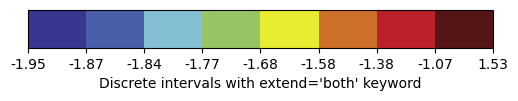

In [79]:
#conservative temperature

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# cmap_deep = plt.cm.get_cmap('cmo.deep')
cmap_deep = mpl.colors.ListedColormap(['#373790', '#4a5ea9', '#85bfd3', '#97c464', '#e8ec31', '#cc6f2a', '#bb2128', '#551416'])

# Calculate percentiles to divide the data into 8 equal parts
#data that has zeroes
#percentiles = np.percentile(thickness['thickness'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
#thickness data with no zeroes
#percentiles = np.percentile(thickness_filtered['thickness'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
#how to set manual values for colour bar ticks
# percentiles = [0, 20, 50, 100, 500, 750, 1000, 1250, 1500]
# #for mean cons temp
percentiles = np.percentile(mean_cons_temperature['mean_cons_temperature'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
#for mean abs salt
#percentiles = np.percentile(mean_abs_salinity['mean_abs_salinity'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%

def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)

norm = mpl.colors.BoundaryNorm(percentiles, cmap_deep.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword", format=formatter)

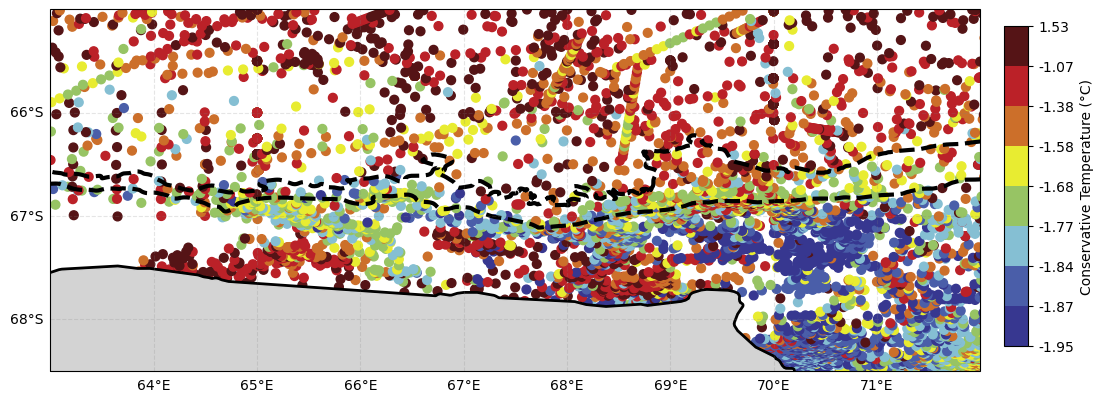

In [80]:
## conservative Temperature

# Set up the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
ax.set_extent([63, 72, -68.5, -65], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 73, 1), ylocs=np.arange(-69, -63, 1))
gl.right_labels = False
gl.top_labels = False


# Plot the thickness data on the map
# #thickness
# sc = ax.scatter(thickness['longitude'], thickness['latitude'], c=thickness['thickness'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)
#mean cons temp 
sc = ax.scatter(mean_cons_temperature['longitude'], mean_cons_temperature['latitude'], c=mean_cons_temperature['mean_cons_temperature'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)
#mean abs salt 
#sc = ax.scatter(mean_abs_salinity['longitude'], mean_abs_salinity['latitude'], c=mean_abs_salinity['mean_abs_salinity'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)


#old original colourbar code
#plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both', label='Thickness (m)')



def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)

# Create a color bar axes
cax = plt.axes([0.92, 0.3, 0.02, 0.4])  # [x, y, width, height]
# Create the color bar using the ScalarMappable
#thickness
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Thickness (m)', format=formatter)
#mean cons temp 
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Conservative Temperature (°C)', format=formatter)
#mean abs salt 
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Absolute Salinity (g/kg)', format=formatter)

#plot 600m contour
ax.plot(shelf_contour[:, 0], shelf_contour[:, 1], color='black', linewidth=3, linestyle='--')
#plot 2000m contour
ax.plot(slope_contour[:, 0], slope_contour[:, 1], color='black', linewidth=3, linestyle='--')

# cbar = plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
# cbar.set_label(f'Thickness (m)', fontsize=11)

# plt.title('Thickness of Criteria: Neutral Density < 28 kg/m$^3$, Depth < 700m')
#plt.title('Thickness of Criteria: Neutral Density 28 < y$^n$ < 28.27 kg/m$^3$')
plt.show()


In [81]:
# create 2 grids, one for the sum total, and one that has the count of points within grid. Then divide grids by eachother to find the mean 


# Create a DataFrame from the NumPy array
data = pd.DataFrame(mean_cons_temperature, columns=['latitude', 'longitude', 'mean_cons_temperature'])


# Define the grid resolution (0.1 degrees in this case) and the range of latitudes and longitudes you want to cover:
lat_resolution = 0.1
lon_resolution = 0.1

min_lat = -69
max_lat = -63
min_lon = 63
max_lon = 73


# Create empty grids for latitude, longitude, and temperature totals
latitudes = np.arange(min_lat, max_lat + lat_resolution, lat_resolution)
longitudes = np.arange(min_lon, max_lon + lon_resolution, lon_resolution)
total_temperature_grid = np.zeros((len(latitudes), len(longitudes)))
count_grid = np.zeros((len(latitudes), len(longitudes)))


# Iterate through each data point and accumulate the temperature values into the corresponding grid cell
for index, row in data.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    temperature = row['mean_cons_temperature']

    lat_index = int((lat - min_lat) / lat_resolution)
    lon_index = int((lon - min_lon) / lon_resolution)

    total_temperature_grid[lat_index, lon_index] += temperature
    count_grid[lat_index, lon_index] += 1


# Replace zero values in total_temperature_grid with NaN where count is zero
total_temperature_grid[count_grid == 0] = np.nan
# or this line if you want it to do less than x no. of point (e.g. if less than 3 data points, make nan)
# total_temperature_grid[(count_grid == 0) | (count_grid <= 2)] = np.nan


# access the temperature value for a specific grid cell by indexing the temperature_grid
# For example, to get the total temperature at latitude 42.5 and longitude -120.3:
lat_index = int((-67 - min_lat) / lat_resolution)
lon_index = int((65.3 - min_lon) / lon_resolution)

total_temperature = total_temperature_grid[lat_index, lon_index]
count_grid_value = count_grid[lat_index, lon_index]

print(total_temperature)
print(count_grid_value)




# Divide total_temperature_grid by count_grid to calculate the mean
mean_temperature_grid = np.divide(total_temperature_grid, count_grid)

# Access the mean temperature value for a specific grid cell by indexing the mean_temperature_grid
# For example, to get the mean temperature at latitude -67 and longitude 65.3:
mean_temperature = mean_temperature_grid[lat_index, lon_index]

print(mean_temperature)


-10.367006299571447
6.0
-1.7278343832619079


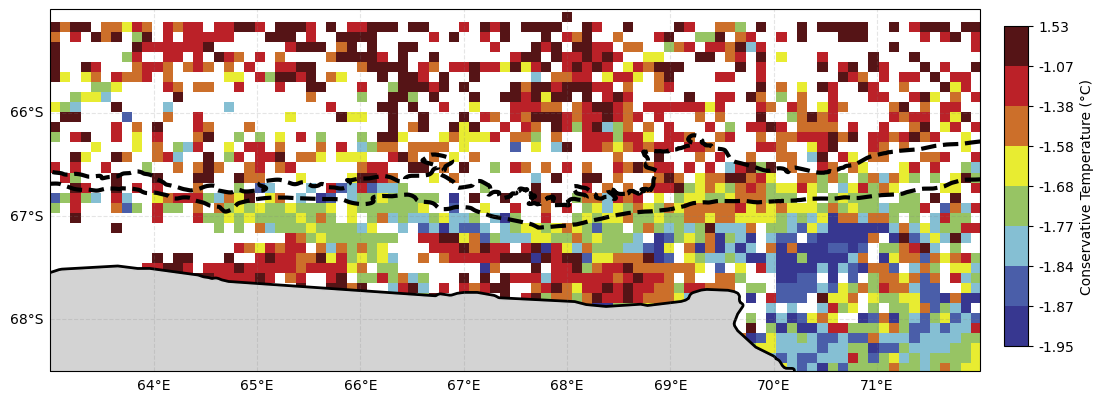

In [82]:
#gridded absolute temperature
# Set up the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
ax.set_extent([63, 72, -68.5, -65], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 73, 1), ylocs=np.arange(-69, -63, 1))
gl.right_labels = False
gl.top_labels = False


# Plot the temperature grid
plt.imshow(mean_temperature_grid, extent=[min_lon, max_lon, min_lat, max_lat], cmap=cmap_deep, origin='lower', transform=ccrs.PlateCarree(), norm=norm)

#old original colourbar code
#plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both', label='Thickness (m)')


def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)


# Create a color bar axes
cax = plt.axes([0.92, 0.3, 0.02, 0.4])  # [x, y, width, height]
# Create the color bar using the ScalarMappable
#thickness
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Thickness (m)', format=formatter)
# #mean cons temp 
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Conservative Temperature (°C)', format=formatter)
#mean abs salt 
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Absolute Salinity (g/kg)', format=formatter)

#plot 600m contour
ax.plot(shelf_contour[:, 0], shelf_contour[:, 1], color='black', linewidth=3, linestyle='--')
#plot 2000m contour
ax.plot(slope_contour[:, 0], slope_contour[:, 1], color='black', linewidth=3, linestyle='--')

# cbar = plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
# cbar.set_label(f'Thickness (m)', fontsize=11)

# plt.title('Thickness of Criteria: Neutral Density < 28 kg/m$^3$, Depth < 700m')
# plt.title('Thickness of Criteria: Neutral Density 28 < y$^n$ < 28.27 kg/m$^3$')
plt.show()


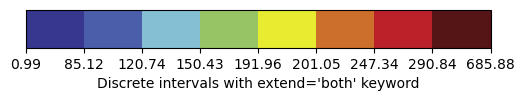

In [83]:
#thickness

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# cmap_deep = plt.cm.get_cmap('cmo.deep')
cmap_deep = mpl.colors.ListedColormap(['#373790', '#4a5ea9', '#85bfd3', '#97c464', '#e8ec31', '#cc6f2a', '#bb2128', '#551416'])

# Calculate percentiles to divide the data into 8 equal parts
#data that has zeroes
#percentiles = np.percentile(thickness['thickness'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
#thickness data with no zeroes
percentiles = np.percentile(thickness_filtered['thickness'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
#how to set manual values for colour bar ticks
# percentiles = [0, 20, 50, 100, 500, 750, 1000, 1250, 1500]
# #for mean cons temp
#percentiles = np.percentile(mean_cons_temperature['mean_cons_temperature'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
#for mean abs salt
#percentiles = np.percentile(mean_abs_salinity['mean_abs_salinity'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%

def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)

norm = mpl.colors.BoundaryNorm(percentiles, cmap_deep.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword", format=formatter)

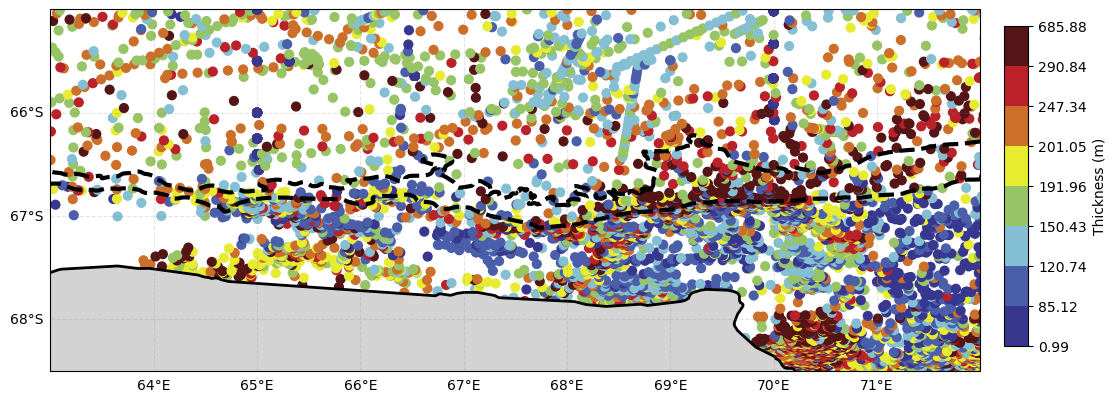

In [84]:
## thickness

# Set up the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
ax.set_extent([63, 72, -68.5, -65], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 73, 1), ylocs=np.arange(-69, -63, 1))
gl.right_labels = False
gl.top_labels = False


# Plot the thickness data on the map
# #thickness
sc = ax.scatter(thickness_filtered['longitude'], thickness_filtered['latitude'], c=thickness_filtered['thickness'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)
#mean cons temp 
#sc = ax.scatter(mean_cons_temperature['longitude'], mean_cons_temperature['latitude'], c=mean_cons_temperature['mean_cons_temperature'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)
#mean abs salt 
#sc = ax.scatter(mean_abs_salinity['longitude'], mean_abs_salinity['latitude'], c=mean_abs_salinity['mean_abs_salinity'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)


#old original colourbar code
#plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both', label='Thickness (m)')



def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)

# Create a color bar axes
cax = plt.axes([0.92, 0.3, 0.02, 0.4])  # [x, y, width, height]
# Create the color bar using the ScalarMappable
#thickness
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Thickness (m)', format=formatter)
#mean cons temp 
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Conservative Temperature (°C)', format=formatter)
#mean abs salt 
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Absolute Salinity (g/kg)', format=formatter)


#plot 600m contour
ax.plot(shelf_contour[:, 0], shelf_contour[:, 1], color='black', linewidth=3, linestyle='--')
#plot 2000m contour
ax.plot(slope_contour[:, 0], slope_contour[:, 1], color='black', linewidth=3, linestyle='--')

# cbar = plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
# cbar.set_label(f'Thickness (m)', fontsize=11)

# plt.title('Thickness of Criteria: Neutral Density < 28 kg/m$^3$, Depth < 700m')
#plt.title('Thickness of Criteria: Neutral Density 28 < y$^n$ < 28.27 kg/m$^3$')
plt.show()


In [85]:
#thickness
# create 2 grids, one for the sum total, and one that has the count of points within grid. Then divide grids by eachother to find the mean 


# Create a DataFrame from the NumPy array
data = pd.DataFrame(thickness_filtered, columns=['latitude', 'longitude', 'thickness'])


# Define the grid resolution (0.1 degrees in this case) and the range of latitudes and longitudes you want to cover:
lat_resolution = 0.1
lon_resolution = 0.1

min_lat = -69
max_lat = -63
min_lon = 63
max_lon = 73


# Create empty grids for latitude, longitude, and thickness totals
latitudes = np.arange(min_lat, max_lat + lat_resolution, lat_resolution)
longitudes = np.arange(min_lon, max_lon + lon_resolution, lon_resolution)
total_thickness_grid = np.zeros((len(latitudes), len(longitudes)))
count_grid = np.zeros((len(latitudes), len(longitudes)))


# Iterate through each data point and accumulate the thickness values into the corresponding grid cell
for index, row in data.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    thickness = row['thickness']

    lat_index = int((lat - min_lat) / lat_resolution)
    lon_index = int((lon - min_lon) / lon_resolution)

    total_thickness_grid[lat_index, lon_index] += thickness
    count_grid[lat_index, lon_index] += 1


# Replace zero values in total_thickness_grid with NaN where count is zero
total_thickness_grid[count_grid == 0] = np.nan
# or this line if you want it to do less than x no. of point (e.g. if less than 3 data points, make nan)
# total_thickness_grid[(count_grid == 0) | (count_grid <= 2)] = np.nan


# access the thickness value for a specific grid cell by indexing the thickness_grid
# For example, to get the total thickness at latitude 42.5 and longitude -120.3:
lat_index = int((-67 - min_lat) / lat_resolution)
lon_index = int((65.3 - min_lon) / lon_resolution)

total_thickness = total_thickness_grid[lat_index, lon_index]
count_grid_value = count_grid[lat_index, lon_index]

print(total_thickness)
print(count_grid_value)




# Divide total_thickness_grid by count_grid to calculate the mean
mean_thickness_grid = np.divide(total_thickness_grid, count_grid)

# Access the mean thickness value for a specific grid cell by indexing the mean_thickness_grid
# For example, to get the mean thickness at latitude -67 and longitude 65.3:
mean_thickness = mean_thickness_grid[lat_index, lon_index]

print(mean_thickness)


882.7275052769078
6.0
147.12125087948462


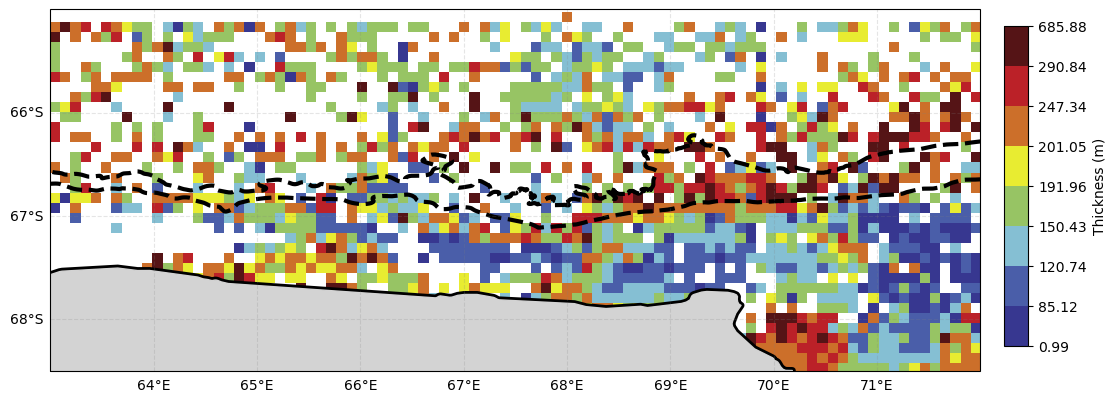

In [86]:
#gridded  thickness
# Set up the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
ax.set_extent([63, 72, -68.5, -65], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 73, 1), ylocs=np.arange(-69, -63, 1))
gl.right_labels = False
gl.top_labels = False


# Plot the thickness grid
plt.imshow(mean_thickness_grid, extent=[min_lon, max_lon, min_lat, max_lat], cmap=cmap_deep, origin='lower', transform=ccrs.PlateCarree(), norm=norm)

#old original colourbar code
#plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both', label='Thickness (m)')


def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)


# Create a color bar axes
cax = plt.axes([0.92, 0.3, 0.02, 0.4])  # [x, y, width, height]
# Create the color bar using the ScalarMappable
#thickness
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Thickness (m)', format=formatter)
# #mean cons temp 
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Conservative Temperature (°C)', format=formatter)
#mean abs salt 
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Absolute Salinity (g/kg)', format=formatter)

#plot 600m contour
ax.plot(shelf_contour[:, 0], shelf_contour[:, 1], color='black', linewidth=3, linestyle='--')
#plot 2000m contour
ax.plot(slope_contour[:, 0], slope_contour[:, 1], color='black', linewidth=3, linestyle='--')

# cbar = plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
# cbar.set_label(f'Thickness (m)', fontsize=11)

# plt.title('Thickness of Criteria: Neutral Density < 28 kg/m$^3$, Depth < 700m')
# plt.title('Thickness of Criteria: Neutral Density 28 < y$^n$ < 28.27 kg/m$^3$')
plt.show()


In [38]:
########################################################################################################
########################################################################################################
##################################### Gridded depth layers plotting ####################################
########################################################################################################
########################################################################################################

In [101]:
#run this code for bottom of cast 
# Combine your data into a single DataFrame for easier processing
data = pd.DataFrame({
    'latitude': latitude,
    'longitude': longitude,
    'depth': depth,
    'temperature': temperature,
    'cons_temperature': cons_temperature,
    'salinity': salinity,
    'abs_salinity': abs_salinity,
    'oxygen': oxygen,
    'pressure': pressure,
    'neutral_density': neutral_density,
    'time': time,
    'type': type
})

# Find the maximum depth for each unique latitude and longitude combination
max_depth_data = data.groupby(['latitude', 'longitude'])['depth'].max().reset_index()

# Merge the original data with the maximum depth data to get the data at the maximum depth
result = pd.merge(data, max_depth_data, on=['latitude', 'longitude', 'depth'], how='inner')


# Rename the 'absolute salinity' column to 'mean_abs_salinity'
result.rename(columns={'abs_salinity': 'mean_abs_salinity'}, inplace=True)
result.rename(columns={'cons_temperature': 'mean_cons_temperature'}, inplace=True)
result.rename(columns={'oxygen': 'mean_oxygen'}, inplace=True)

# print(result)

mean_abs_salinity = result[['latitude', 'longitude', 'mean_abs_salinity', 'depth']]
mean_cons_temperature = result[['latitude', 'longitude', 'mean_cons_temperature', 'depth']]
mean_oxygen = result[['latitude', 'longitude', 'mean_oxygen', 'depth']]

print(mean_cons_temperature)

#print(max_depth_data)


        latitude  longitude  mean_cons_temperature        depth
0     -65.702000  69.868000               0.093330  1965.068396
1     -65.981674  71.213150              -0.067608  1919.534932
2     -65.965000  64.149000               0.022040  1971.555121
3     -66.761550  64.339200              -0.301034  1270.379540
4     -64.137000  64.398667              -0.458718  3349.121278
...          ...        ...                    ...          ...
14018 -66.168320  67.602210              -0.023833  1913.231752
14019 -65.529060  65.597560               0.100562  1871.026705
14020 -65.124000  70.954000               0.011429  1969.414601
14021 -67.311670  65.890000              -1.714024   110.854491
14022 -66.036644  68.335320              -0.065558  1968.779574

[14023 rows x 4 columns]


In [88]:
# Filter data based on criteria (neutral_density < 28 and depth < 2000)
#choose your depth

# #100m
# criteria_indices = np.where(np.logical_and(50 < depth, depth < 150))
#300m
criteria_indices = np.where(np.logical_and(250 < depth, depth < 350))
# #500m
# criteria_indices = np.where(np.logical_and(450 < depth, depth < 550))
# #1000m
# criteria_indices = np.where(np.logical_and(900 < depth, depth < 1100))
# #2000m
# criteria_indices = np.where(np.logical_and(1900 < depth, depth < 2100))
# #3000m
# criteria_indices = np.where(np.logical_and(2900 < depth, depth < 3100))
# #4000m
# criteria_indices = np.where(np.logical_and(3900 < depth, depth < 4100))


# Create a DataFrame with the filtered data
filtered_data = pd.DataFrame({
    'latitude': latitude[criteria_indices],
    'longitude': longitude[criteria_indices],
    'depth': depth[criteria_indices],
    'absolute salinity': abs_salinity[criteria_indices],
    'conservative temperature': cons_temperature[criteria_indices],
    'oxygen': oxygen[criteria_indices]
})


# Group the data by unique latitude and longitude and calculate thickness
grouped = filtered_data.groupby(['latitude', 'longitude'])
mean_abs_salinity = grouped['absolute salinity'].mean().reset_index(name='mean_abs_salinity')
mean_cons_temperature = grouped['conservative temperature'].mean().reset_index(name='mean_cons_temperature')
mean_oxygen = grouped['oxygen'].mean().reset_index(name='mean_oxygen')

print(mean_oxygen)

       latitude  longitude  mean_oxygen
0    -68.814330  72.658330          NaN
1    -68.753334  72.835000          NaN
2    -68.725000  71.100000          NaN
3    -68.708700  72.901700   318.649466
4    -68.702700  72.922700   327.601395
...         ...        ...          ...
7331 -64.137000  64.398667   258.136701
7332 -63.999500  68.000000          NaN
7333 -63.499000  67.998340          NaN
7334 -63.199533  68.999417   207.872016
7335 -63.000500  68.002330          NaN

[7336 rows x 3 columns]


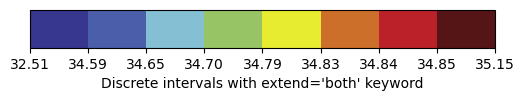

In [102]:
#absolute salinity

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# cmap_deep = plt.cm.get_cmap('cmo.deep')
cmap_deep = mpl.colors.ListedColormap(['#373790', '#4a5ea9', '#85bfd3', '#97c464', '#e8ec31', '#cc6f2a', '#bb2128', '#551416'])

# Calculate percentiles to divide the data into 8 equal parts
# #for mean cons temp
# percentiles = np.nanpercentile(mean_cons_temperature['mean_cons_temperature'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
#for mean abs salt
percentiles = np.nanpercentile(mean_abs_salinity['mean_abs_salinity'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%

def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)

norm = mpl.colors.BoundaryNorm(percentiles, cmap_deep.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword", format=formatter)

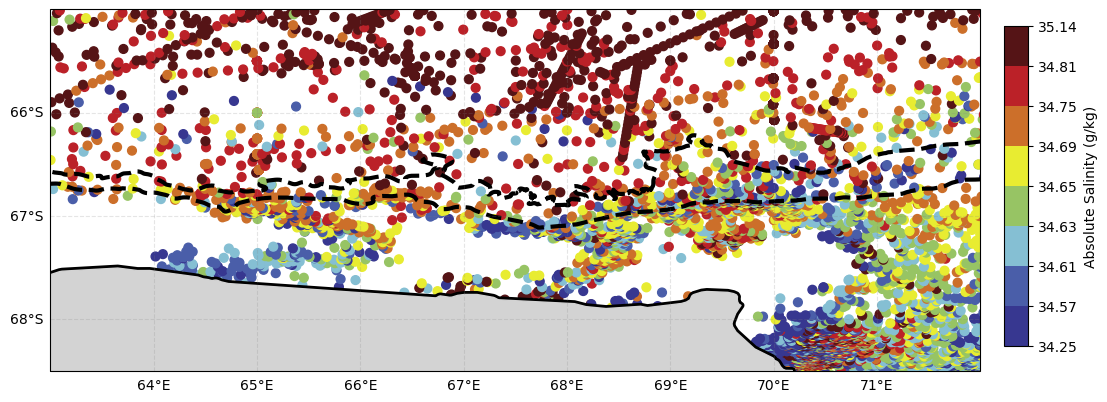

In [90]:
#absolute salinity

# Set up the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
ax.set_extent([63, 72, -68.5, -65], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 73, 1), ylocs=np.arange(-69, -63, 1))
gl.right_labels = False
gl.top_labels = False


# Plot the thickness data on the map
# #thickness
# sc = ax.scatter(thickness['longitude'], thickness['latitude'], c=thickness['thickness'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)
#mean cons temp 
#sc = ax.scatter(mean_cons_temperature['longitude'], mean_cons_temperature['latitude'], c=mean_cons_temperature['mean_cons_temperature'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)
#mean abs salt 
sc = ax.scatter(mean_abs_salinity['longitude'], mean_abs_salinity['latitude'], c=mean_abs_salinity['mean_abs_salinity'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)


#old original colourbar code
#plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both', label='Thickness (m)')



def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)

# Create a color bar axes
cax = plt.axes([0.92, 0.3, 0.02, 0.4])  # [x, y, width, height]
# Create the color bar using the ScalarMappable
#thickness
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Thickness (m)', format=formatter)
#mean cons temp 
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Conservative Temperature (°C)', format=formatter)
#mean abs salt 
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Absolute Salinity (g/kg)', format=formatter)


#plot 600m contour
ax.plot(shelf_contour[:, 0], shelf_contour[:, 1], color='black', linewidth=3, linestyle='--')
#plot 2000m contour
ax.plot(slope_contour[:, 0], slope_contour[:, 1], color='black', linewidth=3, linestyle='--')

# cbar = plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
# cbar.set_label(f'Thickness (m)', fontsize=11)

# plt.title('Thickness of Criteria: Neutral Density < 28 kg/m$^3$, Depth < 700m')
#plt.title('Thickness of Criteria: Neutral Density 28 < y$^n$ < 28.27 kg/m$^3$')
plt.show()


In [103]:
# create 2 grids, one for the sum total, and one that has the count of points within grid. Then divide grids by eachother to find the mean 


# Create a DataFrame from the NumPy array
data = pd.DataFrame(mean_abs_salinity, columns=['latitude', 'longitude', 'mean_abs_salinity'])


# Define the grid resolution (0.1 degrees in this case) and the range of latitudes and longitudes you want to cover:
lat_resolution = 0.1
lon_resolution = 0.1

min_lat = -69
max_lat = -63
min_lon = 63
max_lon = 73


# Create empty grids for latitude, longitude, and salinity totals
latitudes = np.arange(min_lat, max_lat + lat_resolution, lat_resolution)
longitudes = np.arange(min_lon, max_lon + lon_resolution, lon_resolution)
total_salinity_grid = np.zeros((len(latitudes), len(longitudes)))
count_grid = np.zeros((len(latitudes), len(longitudes)))


# Iterate through each data point and accumulate the salinity values into the corresponding grid cell
for index, row in data.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    salinity = row['mean_abs_salinity']

    lat_index = int((lat - min_lat) / lat_resolution)
    lon_index = int((lon - min_lon) / lon_resolution)

    total_salinity_grid[lat_index, lon_index] += salinity
    count_grid[lat_index, lon_index] += 1


# Replace zero values in total_salinity_grid with NaN where count is zero
total_salinity_grid[count_grid == 0] = np.nan
# or this line if you want it to do less than x no. of point (e.g. if less than 3 data points, make nan)
# total_salinity_grid[(count_grid == 0) | (count_grid <= 2)] = np.nan


# access the salinity value for a specific grid cell by indexing the salinity_grid
# For example, to get the total salinity at latitude 42.5 and longitude -120.3:
lat_index = int((-67 - min_lat) / lat_resolution)
lon_index = int((65.3 - min_lon) / lon_resolution)

total_salinity = total_salinity_grid[lat_index, lon_index]
count_grid_value = count_grid[lat_index, lon_index]

print(total_salinity)
print(count_grid_value)




# Divide total_salinity_grid by count_grid to calculate the mean
mean_salinity_grid = np.divide(total_salinity_grid, count_grid)

# Access the mean salinity value for a specific grid cell by indexing the mean_salinity_grid
# For example, to get the mean salinity at latitude -67 and longitude 65.3:
mean_salinity = mean_salinity_grid[lat_index, lon_index]

print(mean_salinity)


208.4977489640505
6.0
34.74962482734175


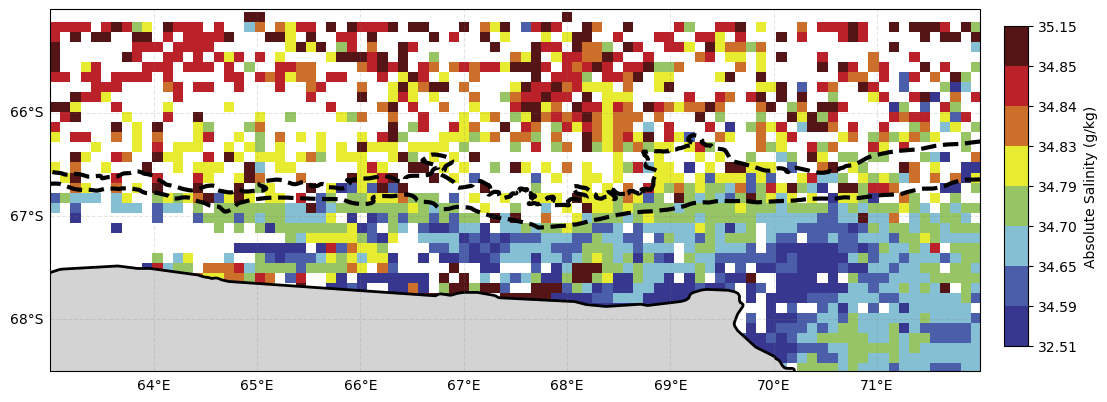

In [104]:
#gridded absolute salinity
# Set up the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
ax.set_extent([63, 72, -68.5, -65], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 73, 1), ylocs=np.arange(-69, -63, 1))
gl.right_labels = False
gl.top_labels = False


# Plot the salinity grid
plt.imshow(mean_salinity_grid, extent=[min_lon, max_lon, min_lat, max_lat], cmap=cmap_deep, origin='lower', transform=ccrs.PlateCarree(), norm=norm)

#old original colourbar code
#plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both', label='Thickness (m)')


def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)


# Create a color bar axes
cax = plt.axes([0.92, 0.3, 0.02, 0.4])  # [x, y, width, height]
# Create the color bar using the ScalarMappable
#thickness
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Thickness (m)', format=formatter)
# #mean cons temp 
# plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Conservative Temperature (°C)', format=formatter)
#mean abs salt 
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Absolute Salinity (g/kg)', format=formatter)


#plot 600m contour
ax.plot(shelf_contour[:, 0], shelf_contour[:, 1], color='black', linewidth=3, linestyle='--')
#plot 2000m contour
ax.plot(slope_contour[:, 0], slope_contour[:, 1], color='black', linewidth=3, linestyle='--')

# cbar = plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
# cbar.set_label(f'Thickness (m)', fontsize=11)

# plt.title('Thickness of Criteria: Neutral Density < 28 kg/m$^3$, Depth < 700m')
# plt.title('Thickness of Criteria: Neutral Density 28 < y$^n$ < 28.27 kg/m$^3$')
plt.show()


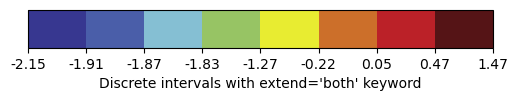

In [105]:
#conservative temperature

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# cmap_deep = plt.cm.get_cmap('cmo.deep')
cmap_deep = mpl.colors.ListedColormap(['#373790', '#4a5ea9', '#85bfd3', '#97c464', '#e8ec31', '#cc6f2a', '#bb2128', '#551416'])

# Calculate percentiles to divide the data into 8 equal parts
# #for mean cons temp
percentiles = np.nanpercentile(mean_cons_temperature['mean_cons_temperature'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
#for mean abs salt
#percentiles = np.nanpercentile(mean_abs_salinity['mean_abs_salinity'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%

def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)

norm = mpl.colors.BoundaryNorm(percentiles, cmap_deep.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword", format=formatter)

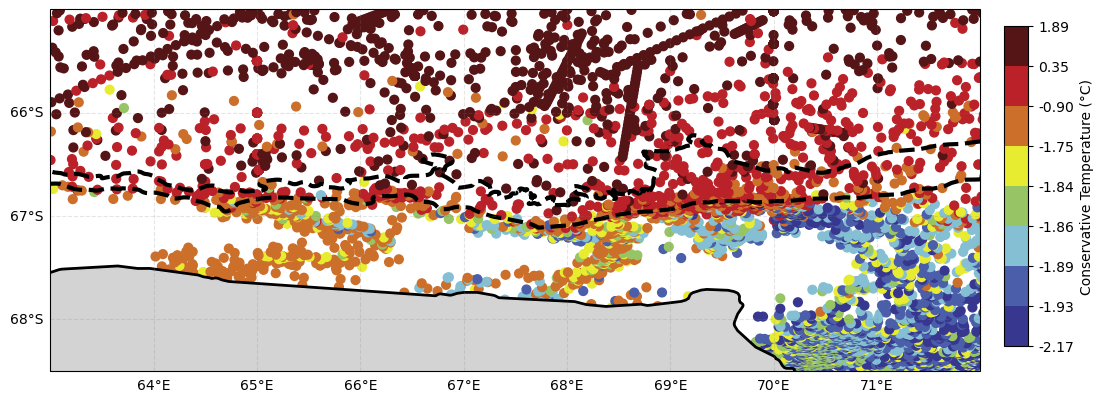

In [94]:
## conservative Temperature

# Set up the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
ax.set_extent([63, 72, -68.5, -65], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 73, 1), ylocs=np.arange(-69, -63, 1))
gl.right_labels = False
gl.top_labels = False


# Plot the thickness data on the map
# #thickness
# sc = ax.scatter(thickness['longitude'], thickness['latitude'], c=thickness['thickness'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)
#mean cons temp 
sc = ax.scatter(mean_cons_temperature['longitude'], mean_cons_temperature['latitude'], c=mean_cons_temperature['mean_cons_temperature'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)
#mean abs salt 
#sc = ax.scatter(mean_abs_salinity['longitude'], mean_abs_salinity['latitude'], c=mean_abs_salinity['mean_abs_salinity'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)


#old original colourbar code
#plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both', label='Thickness (m)')



def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)

# Create a color bar axes
cax = plt.axes([0.92, 0.3, 0.02, 0.4])  # [x, y, width, height]
# Create the color bar using the ScalarMappable
#thickness
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Thickness (m)', format=formatter)
#mean cons temp 
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Conservative Temperature (°C)', format=formatter)
#mean abs salt 
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Absolute Salinity (g/kg)', format=formatter)


#plot 600m contour
ax.plot(shelf_contour[:, 0], shelf_contour[:, 1], color='black', linewidth=3, linestyle='--')
#plot 2000m contour
ax.plot(slope_contour[:, 0], slope_contour[:, 1], color='black', linewidth=3, linestyle='--')

# cbar = plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
# cbar.set_label(f'Thickness (m)', fontsize=11)

# plt.title('Thickness of Criteria: Neutral Density < 28 kg/m$^3$, Depth < 700m')
#plt.title('Thickness of Criteria: Neutral Density 28 < y$^n$ < 28.27 kg/m$^3$')
plt.show()


In [106]:
# create 2 grids, one for the sum total, and one that has the count of points within grid. Then divide grids by eachother to find the mean 


# Create a DataFrame from the NumPy array
data = pd.DataFrame(mean_cons_temperature, columns=['latitude', 'longitude', 'mean_cons_temperature'])


# Define the grid resolution (0.1 degrees in this case) and the range of latitudes and longitudes you want to cover:
lat_resolution = 0.1
lon_resolution = 0.1

min_lat = -69
max_lat = -63
min_lon = 63
max_lon = 73


# Create empty grids for latitude, longitude, and temperature totals
latitudes = np.arange(min_lat, max_lat + lat_resolution, lat_resolution)
longitudes = np.arange(min_lon, max_lon + lon_resolution, lon_resolution)
total_temperature_grid = np.zeros((len(latitudes), len(longitudes)))
count_grid = np.zeros((len(latitudes), len(longitudes)))


# Iterate through each data point and accumulate the temperature values into the corresponding grid cell
for index, row in data.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    temperature = row['mean_cons_temperature']

    lat_index = int((lat - min_lat) / lat_resolution)
    lon_index = int((lon - min_lon) / lon_resolution)

    total_temperature_grid[lat_index, lon_index] += temperature
    count_grid[lat_index, lon_index] += 1


# Replace zero values in total_temperature_grid with NaN where count is zero
total_temperature_grid[count_grid == 0] = np.nan
# or this line if you want it to do less than x no. of point (e.g. if less than 3 data points, make nan)
# total_temperature_grid[(count_grid == 0) | (count_grid <= 2)] = np.nan


# access the temperature value for a specific grid cell by indexing the temperature_grid
# For example, to get the total temperature at latitude 42.5 and longitude -120.3:
lat_index = int((-67 - min_lat) / lat_resolution)
lon_index = int((65.3 - min_lon) / lon_resolution)

total_temperature = total_temperature_grid[lat_index, lon_index]
count_grid_value = count_grid[lat_index, lon_index]

print(total_temperature)
print(count_grid_value)




# Divide total_temperature_grid by count_grid to calculate the mean
mean_temperature_grid = np.divide(total_temperature_grid, count_grid)

# Access the mean temperature value for a specific grid cell by indexing the mean_temperature_grid
# For example, to get the mean temperature at latitude -67 and longitude 65.3:
mean_temperature = mean_temperature_grid[lat_index, lon_index]

print(mean_temperature)


-10.11169746302277
6.0
-1.685282910503795


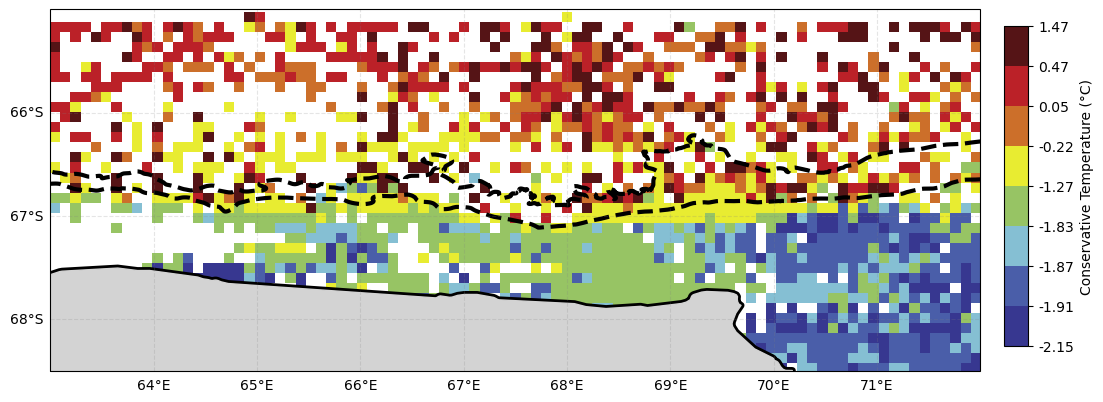

In [107]:
#gridded absolute temperature
# Set up the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
ax.set_extent([63, 72, -68.5, -65], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 73, 1), ylocs=np.arange(-69, -63, 1))
gl.right_labels = False
gl.top_labels = False


# Plot the temperature grid
plt.imshow(mean_temperature_grid, extent=[min_lon, max_lon, min_lat, max_lat], cmap=cmap_deep, origin='lower', transform=ccrs.PlateCarree(), norm=norm)

#old original colourbar code
#plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both', label='Thickness (m)')


def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)


# Create a color bar axes
cax = plt.axes([0.92, 0.3, 0.02, 0.4])  # [x, y, width, height]
# Create the color bar using the ScalarMappable
#thickness
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Thickness (m)', format=formatter)
# #mean cons temp 
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Conservative Temperature (°C)', format=formatter)
#mean abs salt 
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Absolute Salinity (g/kg)', format=formatter)

#plot 600m contour
ax.plot(shelf_contour[:, 0], shelf_contour[:, 1], color='black', linewidth=3, linestyle='--')
#plot 2000m contour
ax.plot(slope_contour[:, 0], slope_contour[:, 1], color='black', linewidth=3, linestyle='--')


# cbar = plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
# cbar.set_label(f'Thickness (m)', fontsize=11)

# plt.title('Thickness of Criteria: Neutral Density < 28 kg/m$^3$, Depth < 700m')
# plt.title('Thickness of Criteria: Neutral Density 28 < y$^n$ < 28.27 kg/m$^3$')
plt.show()


/darnley/miniconda3/envs/devel/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


ValueError: Axis limits cannot be NaN or Inf

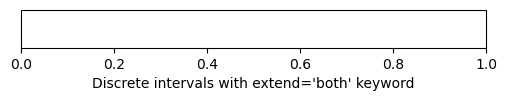

In [108]:
#oxygen

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# cmap_deep = plt.cm.get_cmap('cmo.deep')
cmap_deep = mpl.colors.ListedColormap(['#373790', '#4a5ea9', '#85bfd3', '#97c464', '#e8ec31', '#cc6f2a', '#bb2128', '#551416'])

# Calculate percentiles to divide the data into 8 equal parts
# #for mean cons temp
#percentiles = np.nanpercentile(mean_cons_temperature['mean_cons_temperature'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
#for mean abs salt
#percentiles = np.nanpercentile(mean_abs_salinity['mean_abs_salinity'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%
# #for mean oxygen
percentiles = np.nanpercentile(mean_oxygen['mean_oxygen'], np.arange(0, 101, 12.5))  # 0%, 12.5%, 25%, ..., 100%

def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)

norm = mpl.colors.BoundaryNorm(percentiles, cmap_deep.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword", format=formatter)

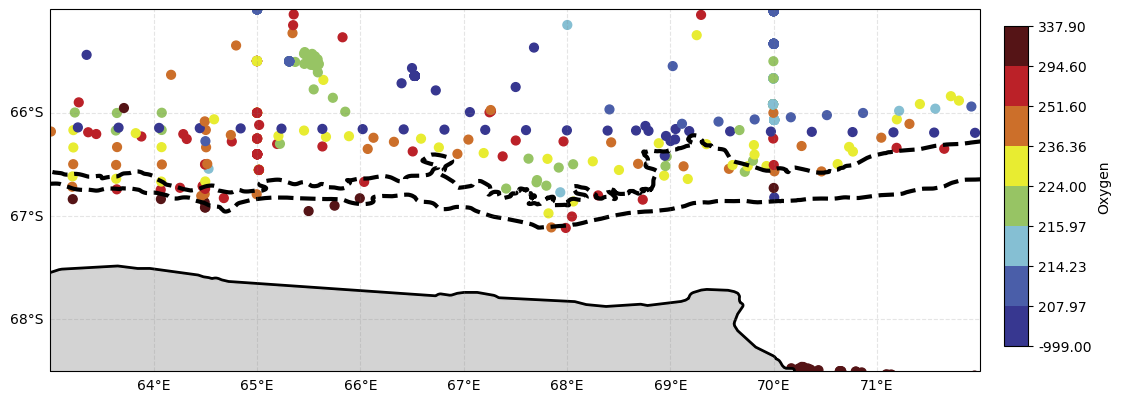

In [98]:
## oxygen

# Set up the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
ax.set_extent([63, 72, -68.5, -65], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 73, 1), ylocs=np.arange(-69, -63, 1))
gl.right_labels = False
gl.top_labels = False


# Plot the thickness data on the map
# #thickness
# sc = ax.scatter(thickness['longitude'], thickness['latitude'], c=thickness['thickness'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)
#mean cons temp 
#sc = ax.scatter(mean_cons_temperature['longitude'], mean_cons_temperature['latitude'], c=mean_cons_temperature['mean_cons_temperature'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)
#mean abs salt 
#sc = ax.scatter(mean_abs_salinity['longitude'], mean_abs_salinity['latitude'], c=mean_abs_salinity['mean_abs_salinity'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)
#mean oxygen
sc = ax.scatter(mean_oxygen['longitude'], mean_oxygen['latitude'], c=mean_oxygen['mean_oxygen'], cmap=cmap_deep, s=40, marker='o', transform=ccrs.PlateCarree(), norm=norm)


#old original colourbar code
#plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both', label='Thickness (m)')



def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)

# Create a color bar axes
cax = plt.axes([0.92, 0.3, 0.02, 0.4])  # [x, y, width, height]
# Create the color bar using the ScalarMappable
#thickness
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Thickness (m)', format=formatter)
#mean cons temp 
# plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Conservative Temperature (°C)', format=formatter)
#mean abs salt 
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Absolute Salinity (g/kg)', format=formatter)
#mean oxygen
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Oxygen', format=formatter)


#plot 600m contour
ax.plot(shelf_contour[:, 0], shelf_contour[:, 1], color='black', linewidth=3, linestyle='--')
#plot 2000m contour
ax.plot(slope_contour[:, 0], slope_contour[:, 1], color='black', linewidth=3, linestyle='--')

# cbar = plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
# cbar.set_label(f'Thickness (m)', fontsize=11)

# plt.title('Thickness of Criteria: Neutral Density < 28 kg/m$^3$, Depth < 700m')
#plt.title('Thickness of Criteria: Neutral Density 28 < y$^n$ < 28.27 kg/m$^3$')
plt.show()


In [ ]:
# create 2 grids, one for the sum total, and one that has the count of points within grid. Then divide grids by eachother to find the mean 


# Create a DataFrame from the NumPy array
data = pd.DataFrame(mean_oxygen, columns=['latitude', 'longitude', 'mean_oxygen'])


# Define the grid resolution (0.1 degrees in this case) and the range of latitudes and longitudes you want to cover:
lat_resolution = 0.1
lon_resolution = 0.1

min_lat = -69
max_lat = -63
min_lon = 63
max_lon = 73


# Create empty grids for latitude, longitude, and oxygen totals
latitudes = np.arange(min_lat, max_lat + lat_resolution, lat_resolution)
longitudes = np.arange(min_lon, max_lon + lon_resolution, lon_resolution)
total_oxygen_grid = np.zeros((len(latitudes), len(longitudes)))
count_grid = np.zeros((len(latitudes), len(longitudes)))


# Iterate through each data point and accumulate the oxygen values into the corresponding grid cell
for index, row in data.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    oxygen = row['mean_oxygen']

    lat_index = int((lat - min_lat) / lat_resolution)
    lon_index = int((lon - min_lon) / lon_resolution)

    total_oxygen_grid[lat_index, lon_index] += oxygen
    count_grid[lat_index, lon_index] += 1


# Replace zero values in total_oxygen_grid with NaN where count is zero
total_oxygen_grid[count_grid == 0] = np.nan
# or this line if you want it to do less than x no. of point (e.g. if less than 3 data points, make nan)
# total_oxygen_grid[(count_grid == 0) | (count_grid <= 2)] = np.nan


# access the oxygen value for a specific grid cell by indexing the oxygen_grid
# For example, to get the total oxygen at latitude 42.5 and longitude -120.3:
lat_index = int((-67 - min_lat) / lat_resolution)
lon_index = int((65.3 - min_lon) / lon_resolution)

total_oxygen = total_oxygen_grid[lat_index, lon_index]
count_grid_value = count_grid[lat_index, lon_index]

print(total_oxygen)
print(count_grid_value)




# Divide total_oxygen_grid by count_grid to calculate the mean
mean_oxygen_grid = np.divide(total_oxygen_grid, count_grid)

# Access the mean oxygen value for a specific grid cell by indexing the mean_oxygen_grid
# For example, to get the mean oxygen at latitude -67 and longitude 65.3:
mean_oxygen = mean_oxygen_grid[lat_index, lon_index]

print(mean_oxygen)


nan
6.0
nan


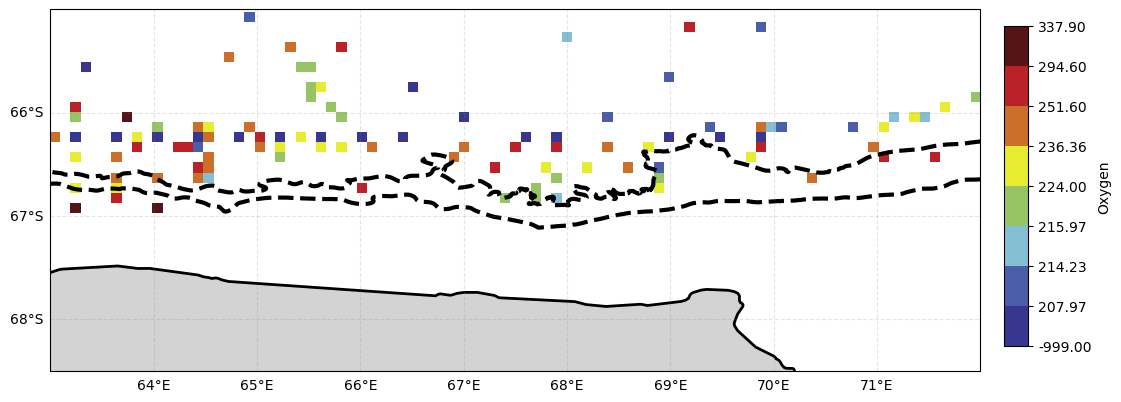

In [ ]:
#gridded absolute oxygen
# Set up the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
ax.set_extent([63, 72, -68.5, -65], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 73, 1), ylocs=np.arange(-69, -63, 1))
gl.right_labels = False
gl.top_labels = False

# Plot the oxygen grid
plt.imshow(mean_oxygen_grid, extent=[min_lon, max_lon, min_lat, max_lat], cmap=cmap_deep, origin='lower', transform=ccrs.PlateCarree(), norm=norm)

def format_ticks(x, pos):
    return f'{x:.2f}'

formatter = ticker.FuncFormatter(format_ticks)

# Create a color bar axes
cax = plt.axes([0.92, 0.3, 0.02, 0.4])  # [x, y, width, height]
# Create the color bar using the ScalarMappable
#thickness
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Thickness (m)', format=formatter)
# #mean cons temp
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Conservative Temperature (°C)', format=formatter)
#mean abs salt
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Absolute Salinity (g/kg)', format=formatter)
#mean oxygen
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_deep), cax=cax, orientation='vertical', label='Oxygen', format=formatter)

#plot 600m contour
ax.plot(shelf_contour[:, 0], shelf_contour[:, 1], color='black', linewidth=3, linestyle='--')
#plot 2000m contour
ax.plot(slope_contour[:, 0], slope_contour[:, 1], color='black', linewidth=3, linestyle='--')

# cbar = plt.colorbar(sc, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
# cbar.set_label(f'Thickness (m)', fontsize=11)

# plt.title('Thickness of Criteria: Neutral Density < 28 kg/m$^3$, Depth < 700m')
# plt.title('Thickness of Criteria: Neutral Density 28 < y$^n$ < 28.27 kg/m$^3$')
plt.show()
